# **Feed Forward Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0001
- Layers: [256, 128, 64]
- Dropout: 0.3


In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [247]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/AveragePooled/split_features_3s_all_1D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [248]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [249]:
train_data = data['train'].copy()
val_data = data['val'].copy()

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [250]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [251]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [252]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **Feed Forward Model**

In [253]:
def build_model(input_features,
                hidden_layers=[256, 128, 64],
                learning_rate=0.0001,
                output_units=20,
                dropout_rate=0.3):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [254]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_1D_annotated.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [255]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [256]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [257]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['cqt'], train_features['melspectrogram']), axis=1)
training_features.shape

(5278, 244)

In [258]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['cqt'], val_features['melspectrogram']), axis=1)
validation_features.shape

(1350, 244)

In [259]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1259 - loss: 2.9183 - val_accuracy: 0.3185 - val_loss: 2.3174
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2963 - loss: 2.2985 - val_accuracy: 0.4237 - val_loss: 2.0409
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3710 - loss: 2.0600 - val_accuracy: 0.4652 - val_loss: 1.8394
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4327 - loss: 1.8547 - val_accuracy: 0.5259 - val_loss: 1.6714
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4831 - loss: 1.6874 - val_accuracy: 0.5274 - val_loss: 1.5699
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5421 - loss: 1.5386 - val_accuracy: 0.5585 - val_loss: 1.4781
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5499 - loss: 1.4729 - val_accuracy: 0.5615 - val_loss: 1.4102
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5765 - loss: 1.3734 - val_accu

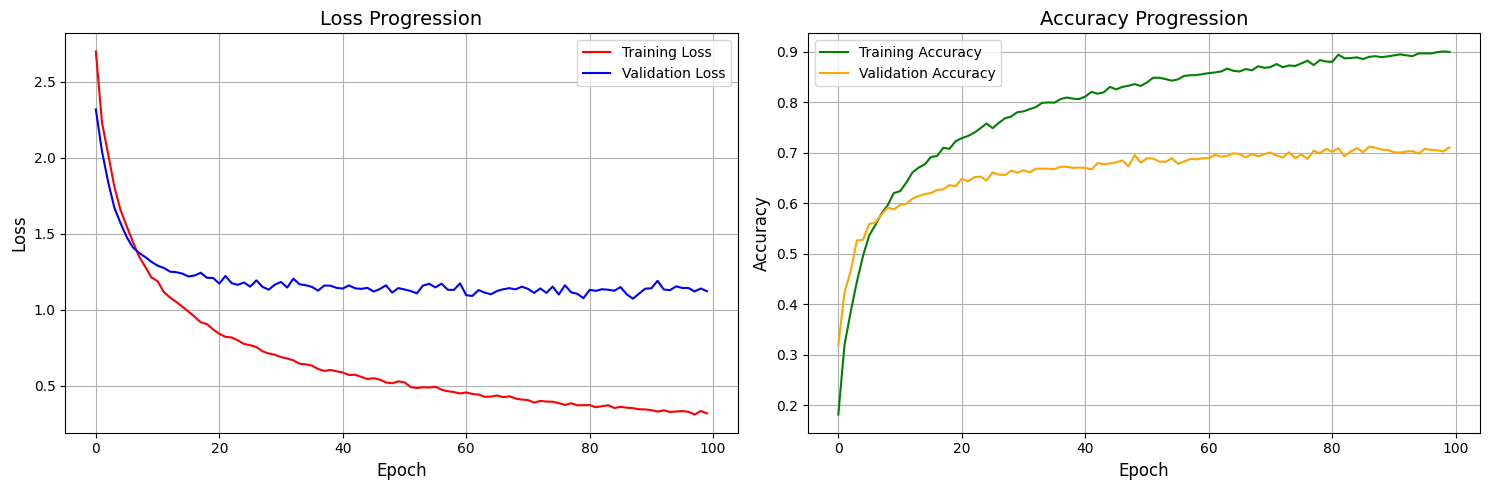

In [260]:
visualize(history, 'all_features')

In [261]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.9587 - loss: 0.1501
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.7058 - loss: 1.1201


In [262]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       114
           1       0.50      0.52      0.51       141
           2       0.79      0.75      0.77       271
           3       0.90      1.00      0.95        90
           4       1.00      0.56      0.71        18
           5       0.83      0.67      0.74        15
           6       0.17      0.26      0.21        23
           7       1.00      1.00      1.00        44
           8       0.56      0.50      0.53        50
           9       0.87      0.96      0.91        49
          10       0.73      0.40      0.51        48
          11       0.51      0.63      0.56        46
          12       0.79      0.83      0.81        54
          13       0.51      0.75      0.61        48
          14       0.55      0.61      0.57        38
          15       0.57      0.50      0.53       117
          16       0.94      0.91      0.93   

### Mel Spectrogram and Chroma

In [263]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)
training_features.shape

(5278, 140)

In [264]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)
validation_features.shape

(1350, 140)

In [265]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1009 - loss: 2.9710 - val_accuracy: 0.3326 - val_loss: 2.4470
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2452 - loss: 2.4594 - val_accuracy: 0.3659 - val_loss: 2.1489
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3222 - loss: 2.2133 - val_accuracy: 0.4096 - val_loss: 1.9367
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3621 - loss: 2.0224 - val_accuracy: 0.4141 - val_loss: 1.7961
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4061 - loss: 1.8867 - val_accuracy: 0.4526 - val_loss: 1.6898
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4246 - loss: 1.7754 - val_accuracy: 0.4756 - val_loss: 1.6193
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4617 - loss: 1.6902 - val_accuracy: 0.5104 - val_loss: 1.5569
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 1.6128 - val_accu

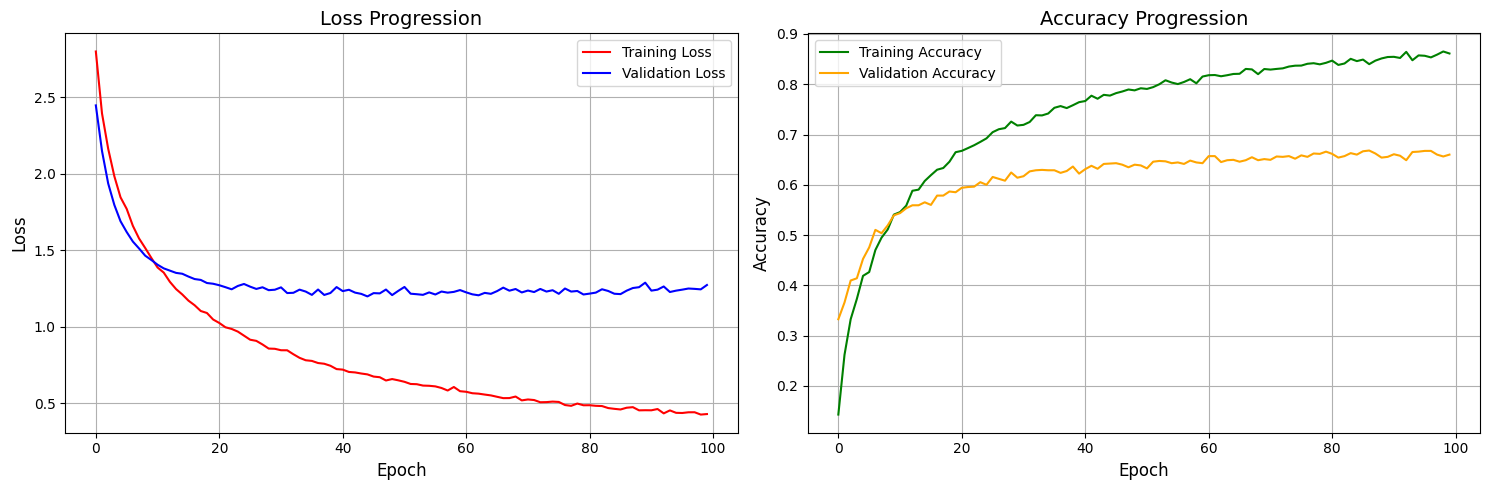

In [266]:
visualize(history, 'melspectrogram_chroma')

In [267]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.9302 - loss: 0.2423
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6547 - loss: 1.2646


In [268]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       114
           1       0.45      0.55      0.49       141
           2       0.77      0.67      0.72       271
           3       0.82      1.00      0.90        90
           4       0.71      0.28      0.40        18
           5       0.67      0.40      0.50        15
           6       0.13      0.17      0.15        23
           7       1.00      0.95      0.98        44
           8       0.48      0.64      0.55        50
           9       0.87      0.96      0.91        49
          10       0.54      0.31      0.39        48
          11       0.47      0.50      0.48        46
          12       0.68      0.67      0.67        54
          13       0.42      0.58      0.49        48
          14       0.63      0.58      0.60        38
          15       0.56      0.42      0.48       117
          16       0.86      0.89      0.88   

### With Mel Spectrogram, MFCCs and Chroma

In [269]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features.shape

(5278, 160)

In [270]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features.shape

(1350, 160)

In [271]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1082 - loss: 2.9520 - val_accuracy: 0.2148 - val_loss: 2.4245
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2351 - loss: 2.4484 - val_accuracy: 0.3207 - val_loss: 2.1734
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2909 - loss: 2.2669 - val_accuracy: 0.4030 - val_loss: 1.9866
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3573 - loss: 2.0724 - val_accuracy: 0.4363 - val_loss: 1.8470
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3919 - loss: 1.9233 - val_accuracy: 0.4763 - val_loss: 1.7272
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4611 - loss: 1.7636 - val_accuracy: 0.5215 - val_loss: 1.6138
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4788 - loss: 1.6486 - val_accuracy: 0.5496 - val_loss: 1.5267
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5187 - loss: 1.5476 - val_accu

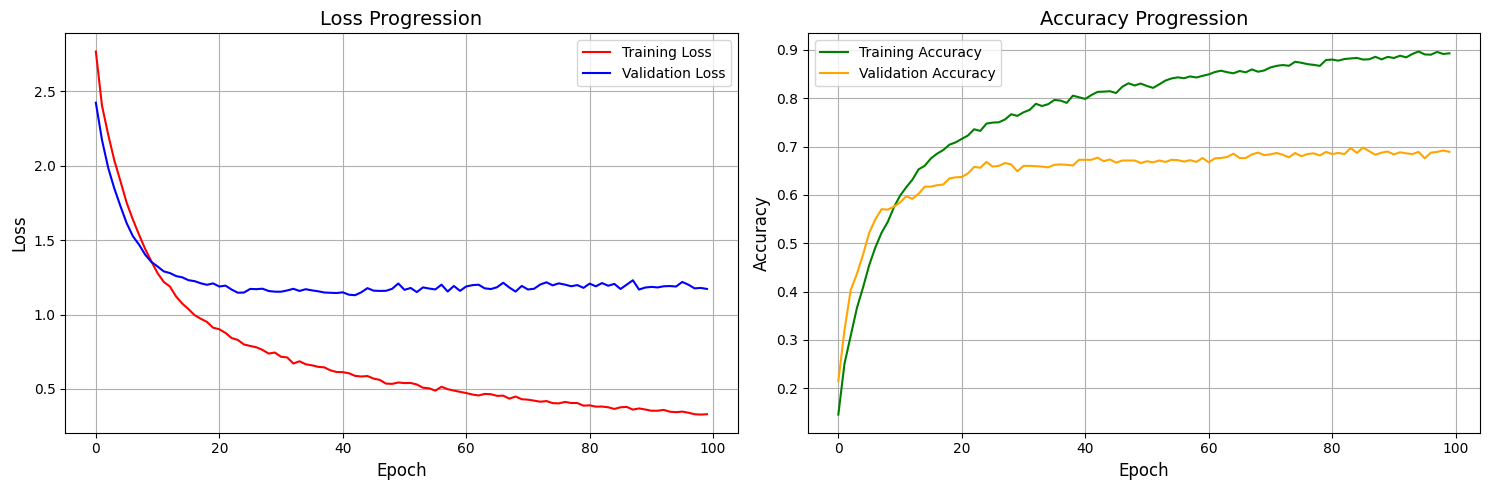

In [272]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [273]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.9576 - loss: 0.1543
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6887 - loss: 1.1752


In [274]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       114
           1       0.43      0.41      0.42       141
           2       0.76      0.72      0.74       271
           3       0.90      1.00      0.95        90
           4       0.82      0.50      0.62        18
           5       0.56      0.60      0.58        15
           6       0.16      0.22      0.19        23
           7       1.00      0.98      0.99        44
           8       0.50      0.56      0.53        50
           9       0.85      0.96      0.90        49
          10       0.81      0.46      0.59        48
          11       0.48      0.30      0.37        46
          12       0.79      0.70      0.75        54
          13       0.48      0.85      0.61        48
          14       0.68      0.84      0.75        38
          15       0.55      0.46      0.50       117
          16       0.91      0.95      0.93   

### With Mel Spectrogram and MFCCs

In [275]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)
training_features.shape

(5278, 148)

In [276]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)
validation_features.shape

(1350, 148)

In [277]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1194 - loss: 2.9151 - val_accuracy: 0.2200 - val_loss: 2.4128
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2537 - loss: 2.4107 - val_accuracy: 0.3200 - val_loss: 2.1445
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3020 - loss: 2.1846 - val_accuracy: 0.3726 - val_loss: 1.9961
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3593 - loss: 2.0778 - val_accuracy: 0.4363 - val_loss: 1.8668
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3890 - loss: 1.9691 - val_accuracy: 0.4681 - val_loss: 1.7609
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4282 - loss: 1.8294 - val_accuracy: 0.4807 - val_loss: 1.6933
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4611 - loss: 1.7219 - val_accuracy: 0.5096 - val_loss: 1.6144
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4963 - loss: 1.6163 - val_accu

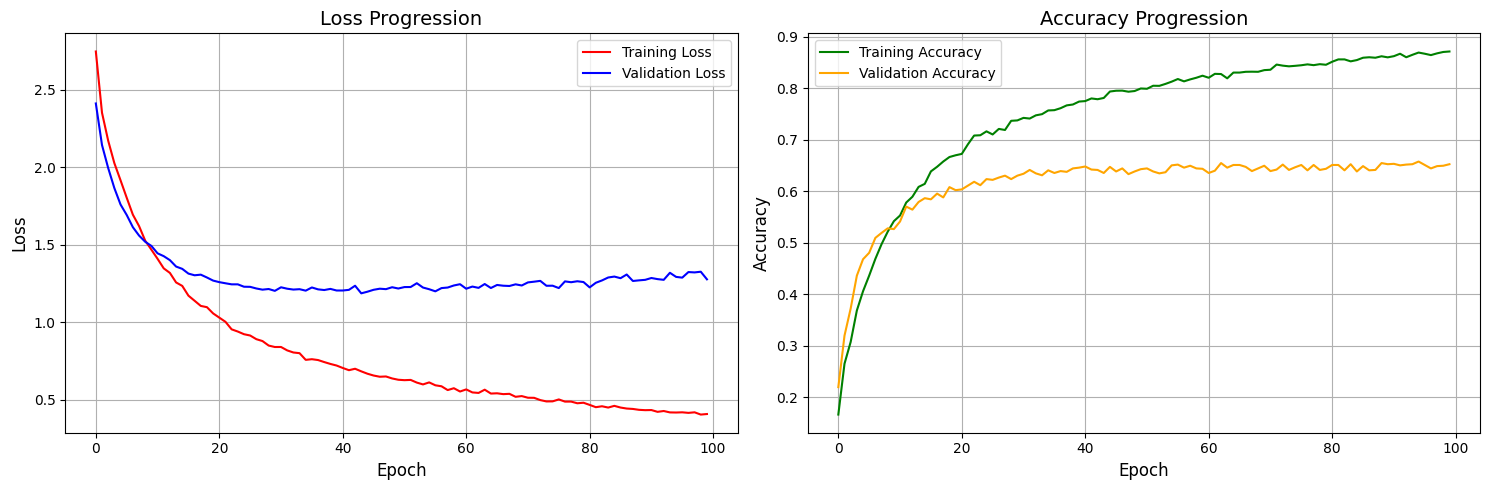

In [278]:
visualize(history, 'mfcc_melspectrogram')

In [279]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9461 - loss: 0.2068
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6525 - loss: 1.2814 


In [280]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       114
           1       0.39      0.47      0.43       141
           2       0.74      0.63      0.68       271
           3       0.86      1.00      0.92        90
           4       1.00      0.33      0.50        18
           5       0.73      0.53      0.62        15
           6       0.21      0.26      0.24        23
           7       0.96      0.98      0.97        44
           8       0.40      0.56      0.47        50
           9       0.87      0.92      0.89        49
          10       0.64      0.19      0.29        48
          11       0.39      0.15      0.22        46
          12       0.70      0.72      0.71        54
          13       0.46      0.83      0.59        48
          14       0.58      0.66      0.62        38
          15       0.59      0.50      0.54       117
          16       0.81      0.95      0.87   

### With Mel Spectrogram

In [281]:
training_features = train_features['melspectrogram']
training_features.shape

(5278, 128)

In [282]:
validation_features = val_features['melspectrogram']
validation_features.shape

(1350, 128)

In [283]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1031 - loss: 3.0022 - val_accuracy: 0.3030 - val_loss: 2.4673
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2244 - loss: 2.5100 - val_accuracy: 0.3637 - val_loss: 2.1902
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3013 - loss: 2.2629 - val_accuracy: 0.4022 - val_loss: 1.9942
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3377 - loss: 2.1097 - val_accuracy: 0.4289 - val_loss: 1.8835
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3808 - loss: 1.9721 - val_accuracy: 0.4511 - val_loss: 1.7686
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4141 - loss: 1.8469 - val_accuracy: 0.4733 - val_loss: 1.7134
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4393 - loss: 1.7650 - val_accuracy: 0.4689 - val_loss: 1.6563
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4475 - loss: 1.7332 - val_accu

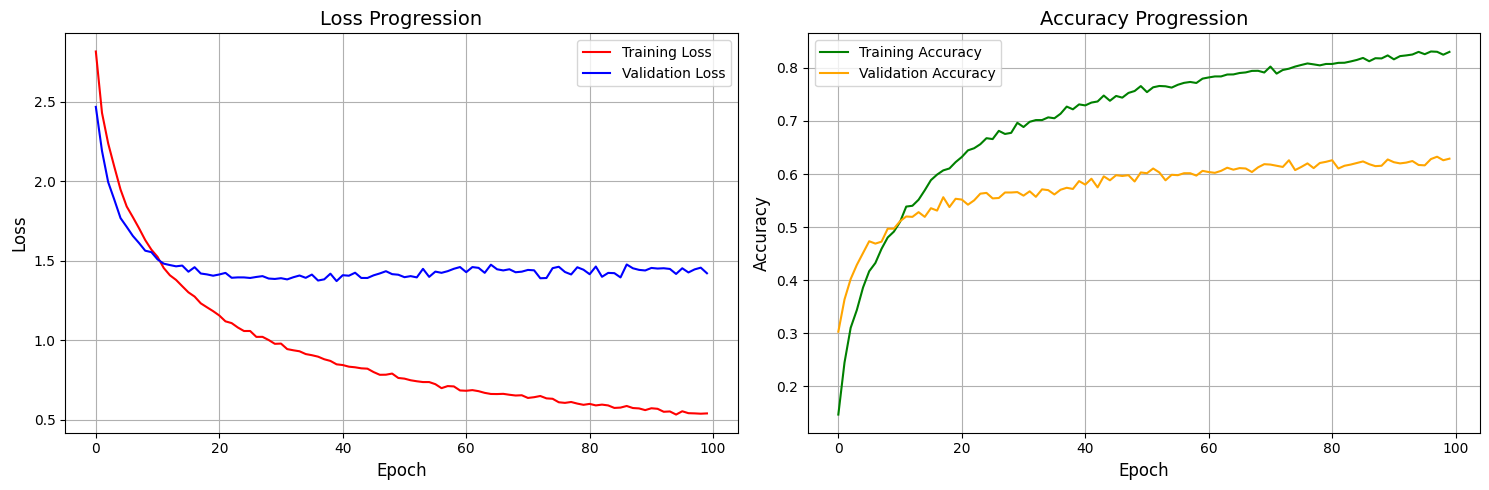

In [284]:
visualize(history, 'melspectrogram')

In [285]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9001 - loss: 0.3330
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 1.4142 


In [286]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.81      0.69      0.75       114
           1       0.39      0.43      0.41       141
           2       0.70      0.66      0.68       271
           3       0.91      1.00      0.95        90
           4       0.78      0.39      0.52        18
           5       0.67      0.27      0.38        15
           6       0.30      0.13      0.18        23
           7       0.96      0.98      0.97        44
           8       0.42      0.48      0.45        50
           9       0.82      0.94      0.88        49
          10       0.41      0.15      0.22        48
          11       0.33      0.11      0.16        46
          12       0.70      0.69      0.69        54
          13       0.32      0.83      0.46        48
          14       0.59      0.53      0.56        38
          15       0.54      0.44      0.49       117
          16       0.81      0.95      0.87   

## Review all the results

In [287]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.954,0.710
4,melspectrogram,0.894,0.629
1,melspectrogram_chroma,0.926,0.660
2,melspectrogram_chroma_mfcc,0.955,0.689
3,mfcc_melspectrogram,0.940,0.653


In [288]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.711      0.962
4              melspectrogram     0.620      0.937
1       melspectrogram_chroma     0.659      0.953
2  melspectrogram_chroma_mfcc     0.686      0.959
3         mfcc_melspectrogram     0.646      0.950
